In [1]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d
from scipy.optimize import curve_fit
from skimage.measure import EllipseModel
from skimage.measure import label as ConnectRegion

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
warnings.filterwarnings('ignore')
import galaxy_phot as glp

In [18]:
sn_name = 'ZTF20acoredl'
gd = glp.galaxy_decomp(sn_name, verbose=True, size='z', source='save', catalog='ztf')
gd.load_main_run()
bd = glp.BDdecomp(sn_name, gd)
bd.load_main_BD(center=False)
bd.galaxy_pars()
bd.classify_gal(verbose=False)

ZTF20acoredl, ra=353.847, dec=-14.798
z=0.0580, z_source=z_gal
dr10 205 205


'bulge'

In [7]:
def prep_px(iso, wi):
    kernal3 = np.array([[ 0,  1,  1],
                        [ -1,  0,  1],
                        [-1,  -1,  0,]])

    kernal_ = 1/(kernal3 + iso)
    kernal_unit = kernal_ / np.sum(kernal_)
    convolve_1 = convolve2d(bd.image['g'], kernal_unit, mode='same')
    convolve_2 = convolve2d(convolve_1, kernal_unit[::-1], mode='same')

    convolve_2[:5,:] = 0
    convolve_2[-5:,:] = 0
    convolve_2[:,:5] = 0
    convolve_2[:,-5:] = 0

    contour = np.stack(np.where((convolve_2.T > iso-wi) & (convolve_2.T < iso+wi)))

    binary_image = np.zeros_like(bd.image['g'], dtype=np.uint8)
    binary_image[contour[0], contour[1]] = 1
    connect_ = ConnectRegion(binary_image, connectivity=2, background=0)
    region_count = np.asarray(np.unique(connect_, return_counts=True)).T[1:].T
    return region_count, connect_


def get_pixels(region, connect): 
    return np.stack(np.where(connect == region))

def super_ellipse_fitter(data):
    ell = EllipseModel()
    ell.estimate(data)
    if ell.params is None:
        return np.zeros(4), np.ones(4)*np.inf, (0,0)
    xc, yc, a, b, pa = ell.params
    x, y = data.T
    r = np.sqrt((x-xc)**2 + (y-yc)**2)
    phi = np.arctan2(y-yc, x-xc)
    out_pars = curve_fit(gd.super_ellipse, phi, r, p0=[a, b, pa, 2], maxfev=5000)
    return out_pars[0], np.sqrt(np.diag(out_pars[1])), (xc, yc)

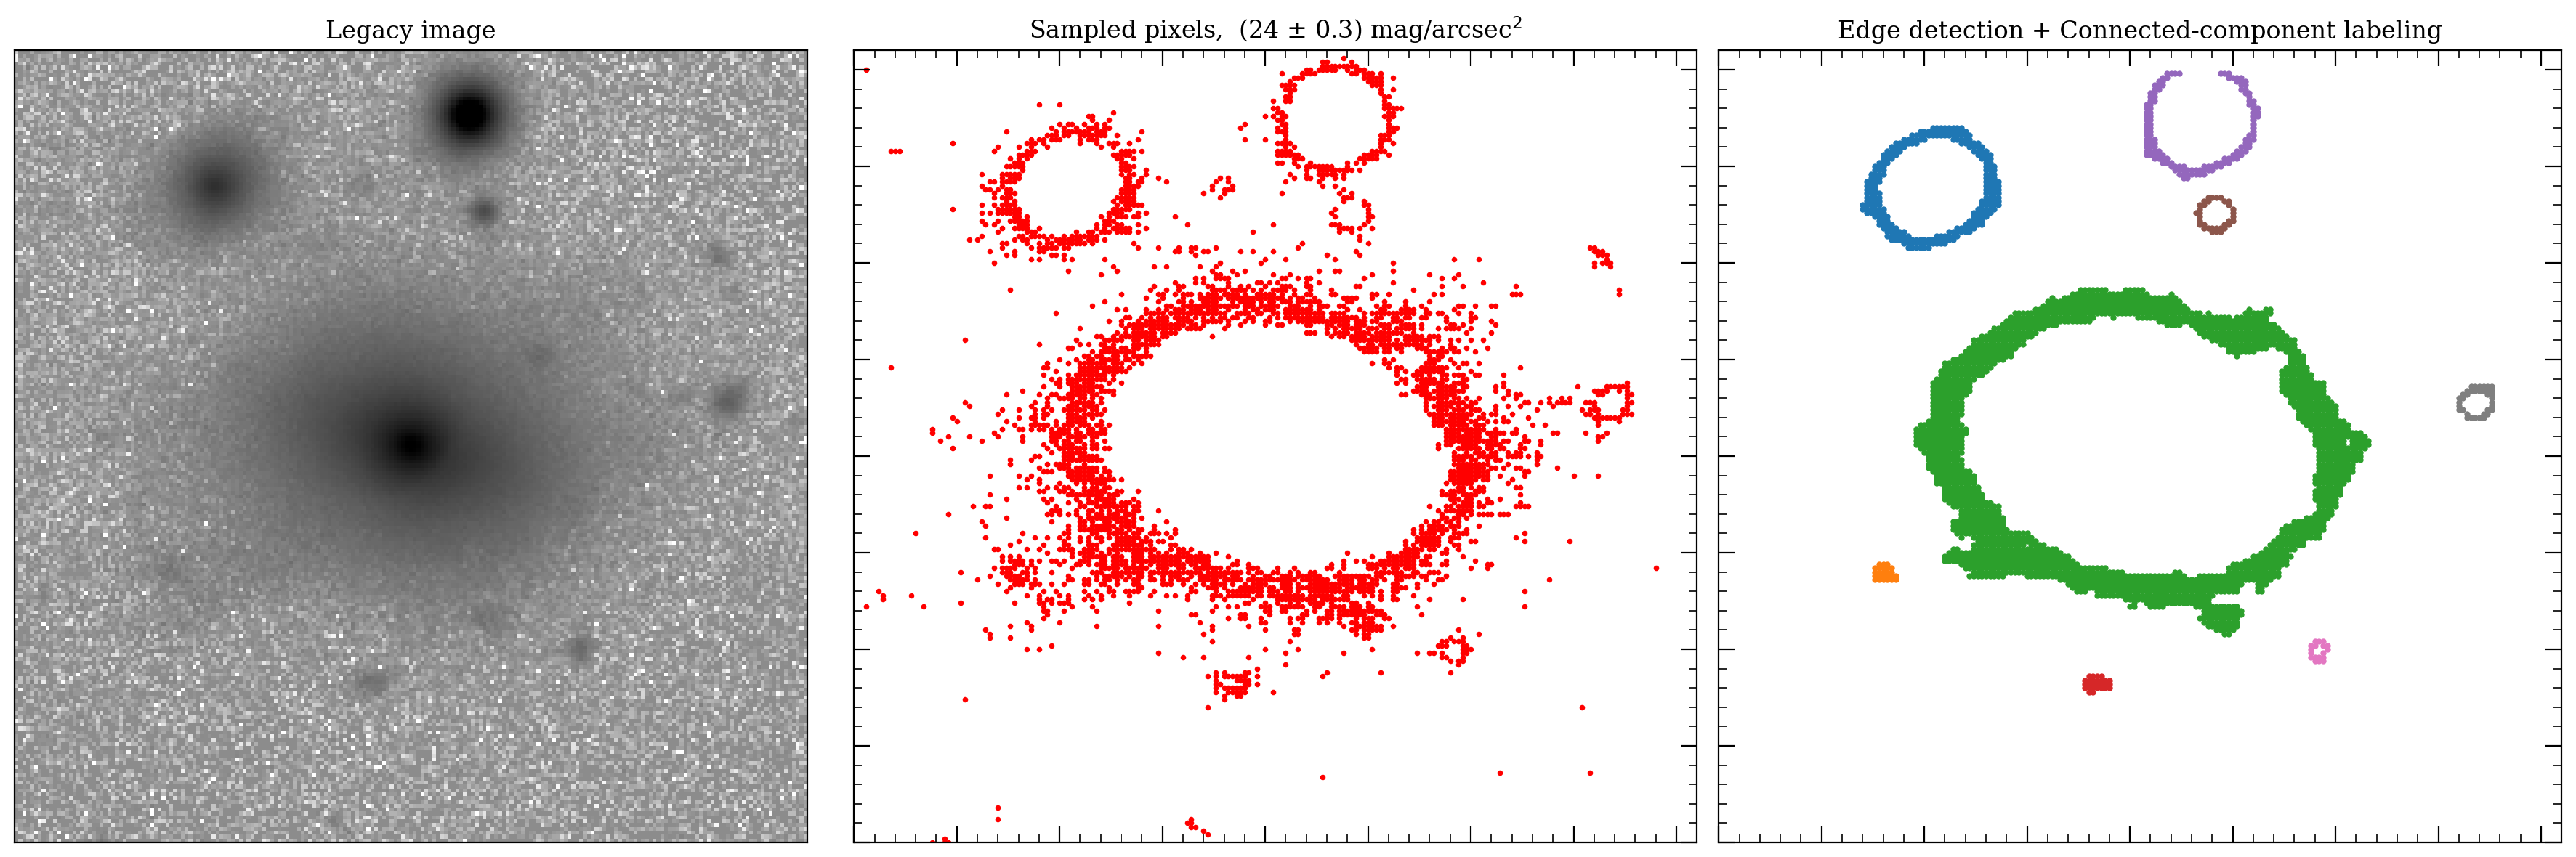

In [8]:
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(18, 6), ncols=3, dpi=200)
sky_mag = bd.gobj['g'].cutout['mag_raw'].copy()
sky_lim = bd.gobj['g'].brick['psfdepth']
sky_mag[np.isnan(sky_mag)] = sky_lim
ci = np.round(bd.center).astype(int)
mag_c = min(19, np.mean(bd.image['g'][ci[0]-1:ci[0]+2, ci[1]-1:ci[1]+2]))
ax1.imshow(sky_mag, origin='lower', cmap='gray', vmax=30, vmin=mag_c)

iso = 24.2
norm = np.stack(np.where((sky_mag.T > iso-0.3) & (sky_mag.T < iso+0.3))).T
ax2.scatter(norm.T[0], norm.T[1], s=3, marker='o', zorder=0, color='red')
ax2.set_ylim([0, len(bd.image['g'])])
ax2.set_xlim([0, len(bd.image['g'])])

count_r, connect = prep_px(iso, 0.3)
for i in range(1, len(count_r.T)):
    data = np.stack(np.where(connect == i)).T
    ax3.plot(data.T[0], data.T[1], marker='o', linestyle='none', ms=2)
ax3.set_ylim([0, len(bd.image['g'])])
ax3.set_xlim([0, len(bd.image['g'])])

ax1.set_title('Legacy image')
ax2.set_title('Sampled pixels,  (24 $\pm$ 0.3) mag/arcsec$^2$')
ax3.set_title('Edge detection + Connected-component labeling')

for ax_i in [ax1, ax2, ax3]:
    ax_i.tick_params(
        axis='both',         
        which='both',     
        bottom=(ax_i !=ax1),     
        top=(ax_i !=ax1),  
        left=(ax_i !=ax1),
        right=(ax_i !=ax1),
        labelleft=False  ,     
        labelbottom=False)
plt.tight_layout()

In [9]:
def patch_super_ellipse(pars, center, ax, color, ms, label=None):
    t_r = np.arange(-np.pi/2, np.pi/2, 0.01)+ pars[2]
    xse, yse = bd.super_ellipse(t_r, *pars, polar=False) 
    xse_t = np.concatenate([xse, -xse])+ center[0]
    yse_t = np.concatenate([yse, -yse])+ center[1]
    ax.plot(xse_t, yse_t, 'r-', color=color, zorder=6, lw=ms, label=label)
    ax.plot(xse_t[[0, -1]], yse_t[[0, -1]], 'r-', color=color, zorder=10, lw=ms)

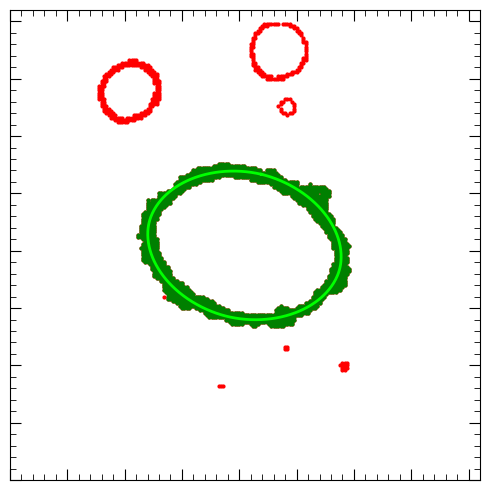

In [11]:
band='g'
fig, ax1 = plt.subplots(figsize=(5, 5), dpi=100)
mag, wcs = bd.image[band], bd.gobj[band].cutout['wcs']

iso=23.8
a, b, theta, n, xc, yc, *err = bd.contours[band][iso][0]
count_r, connect = prep_px(iso, 0.25)
for i in range(1, len(count_r.T)):
    data = np.stack(np.where(connect == i)).T
    ax1.plot(data.T[0], data.T[1], marker='o', linestyle='none', ms=2, c='red')

data = np.stack(np.where(connect == 2)).T
ax1.plot(data.T[0], data.T[1], marker='o', linestyle='none', ms=2, c='green')
patch_super_ellipse((a, b, theta, n), (xc, yc), ax1, 'lime', 2)
ax1.set_ylim([0, len(bd.image['g'])])
ax1.set_xlim([0, len(bd.image['g'])])


spokes = 12
theta_arr =  {'g': np.linspace(0, 360-360/spokes, spokes), 'r': np.linspace(180/spokes, 360-180/spokes, spokes)}
ax2.imshow(sky_mag, cmap='gray', origin='lower')
for row_i in bd.iso_data[band].T[:1:-2]:
    ai, bi, pai, ni, xci, yci, *errs = row_i
    patch_super_ellipse((ai, bi, pai, ni), (xci, yci), ax2, 'lime', 1)

for ax_i in [ax1, ax2]:
    ax_i.tick_params(
        axis='both',         
        which='both',     
        labelleft=False  ,     
        labelbottom=False)

plt.tight_layout()

(<Figure size 1200x600 with 2 Axes>, <AxesSubplot:>)

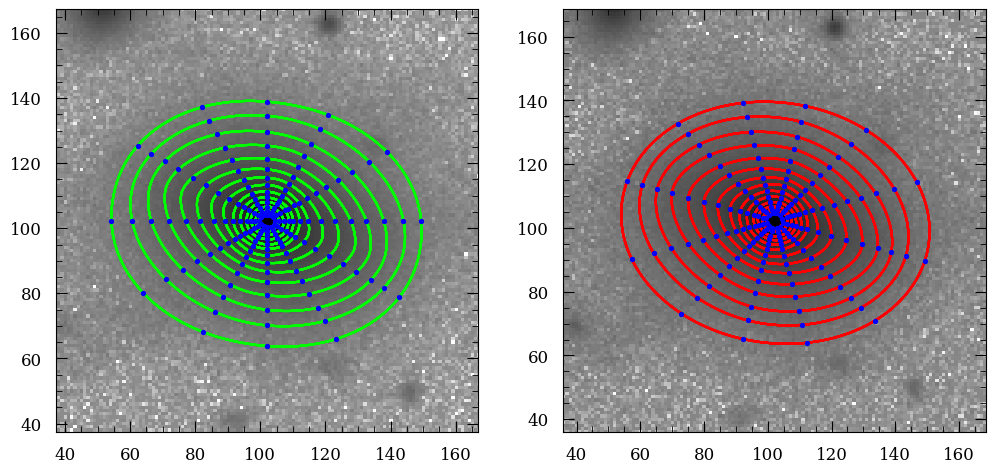

In [20]:
bd.plot_gal_iso(spokes=12)